In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

### Import data and look at first few rows 

In [2]:
file_path = '../data/national-data-master.csv'
data = pd.read_csv(file_path)

In [3]:
data.head()

,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,% Adults Reporting Currently Smoking,...,% 65 and Over,% Black,% American Indian or Alaska Native,% Asian,% Native Hawaiian or Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
0,1000,Alabama,NaN,98140.0,11415.734833,17.8,3.934735,5.869320,10.480008,17.9,...,18.026796,26.430898,0.715863,1.588693,0.109493,4.931778,64.711716,1.047498,51.375324,42.262760
1,1001,Alabama,Autauga,942.0,9407.948438,17.3,3.910265,5.703204,9.871335,16.9,...,16.410917,21.011061,0.471895,1.178065,0.122157,3.381917,72.051072,0.366486,51.296039,40.676813
2,1003,Alabama,Baldwin,3789.0,8981.575353,15.2,3.730943,5.373666,8.124318,15.0,...,21.928703,8.224887,0.810761,1.156086,0.066549,5.036216,82.978473,0.786658,51.239069,37.586455
3,1005,Alabama,Barbour,579.0,13138.848362,27.3,5.023488,6.014294,12.272491,25.0,...,20.622521,47.195013,0.724520,0.469522,0.279284,5.099976,45.272403,1.980660,47.122157,65.919994
4,1007,Alabama,Bibb,501.0,12675.434581,22.0,4.552795,5.824583,9.828571,22.0,...,17.805044,20.736196,0.572597,0.290843,0.131788,3.176551,73.996819,0.289182,46.489434,100.000000


In [4]:
data.shape

(3201, 88)

### Define target variable and import features 

In [5]:
target = '% Adults with Diabetes'
#target = 'HIV Prevalence Rate'
#target = 'Drug Overdose Mortality Rate'

Check distribution of target variable

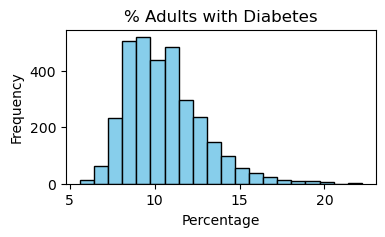

In [6]:
plt.figure(figsize=(4, 2))
plt.hist(data[target].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('% Adults with Diabetes')
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.show()

In [7]:
%run ../data/features-grouped.ipynb #This has a "feature_list" and "features_by_category"

# Rows clean-up

### Find counties with the largest number of missing values

In [8]:
nan_counts = data.isna().sum(axis=1)
data['NaN_Count'] = nan_counts
sorted_data = data.sort_values(by='NaN_Count', ascending=False)
sorted_data[['State', 'County', 'NaN_Count']].head(10)

,State,County,NaN_Count
2970,Virginia,Bedford City,85
98,Alaska,Valdez-Cordova,85
96,Alaska,Skagway-Hoonah-Angoon,85
101,Alaska,Wrangell-Petersburg,85
99,Alaska,Wade Hampton,85
2466,South Dakota,Shannon,85
93,Alaska,Prince of Wales-Outer Ketchikan,85
566,Hawaii,Kalawao,45
74,Alaska,Chugach,35
75,Alaska,Copper River,34


### Drop counties with more than 35 NaN values

In [9]:
dropped_rows = data[data['NaN_Count'] <= 35]

### Drop rows with aggregate state data
These have NaN in the 'County' column. As expected, there are a total of 50 such rows, one per state.

In [10]:
data_reduced_rows = dropped_rows[dropped_rows['County'].notna()]

# Feautures clean-up

### Drop non-numeric features

In [11]:
#numeric_features = [i for i in features if pd.api.types.is_numeric_dtype(data[i])]
non_numeric_features = [i for i in feature_list if not pd.api.types.is_numeric_dtype(data[i])]
non_numeric_features

['Presence of Water Violation']

### Drop features with more than 100 missing values

In [12]:
missing_values = data[feature_list].isnull().sum()

# Filter columns with more than 300 missing values and sort them in descending order
missing_values_filtered = missing_values[missing_values > 100].sort_values(ascending=False) #100 is ~3% of the total number of rows

print("\nMissing Values per Column (More than 100):")
print(missing_values_filtered)


Missing Values per Column (More than 100):
% Disconnected Youth                     1977
Infant Mortality Rate                    1944
Homicide Rate                            1774
Juvenile Arrest Rate                     1255
Drug Overdose Mortality Rate             1251
Child Mortality Rate                     1112
Segregation Index.1                      1074
Firearm Fatalities Rate                   871
Suicide Rate (Age-Adjusted)               723
High School Graduation Rate               685
% Enrolled in Free or Reduced Lunch       559
Average Grade Performance.1               463
Motor Vehicle Mortality Rate              462
HIV Prevalence Rate                       462
Average Grade Performance                 376
Deaths                                    264
Years of Potential Life Lost Rate         264
Segregation Index                         228
Teen Birth Rate                           223
Mental Health Provider Rate               192
Primary Care Physicians Rate        

In [13]:
features_to_drop = missing_values_filtered.index.tolist()
filtered_features = [i for i in feature_list if i not in features_to_drop and i not in non_numeric_features]
np.size(filtered_features)

59

### Drop health outcomes that aren't the target variable

In [14]:
filtered_features = [feature for feature in filtered_features if feature not in features_by_category["Health Outcomes"]]
np.size(filtered_features)

51

### Drop features that are redundant or obviously correlated

In [15]:
red_features = ['Life Expectancy',
            'Years of Potential Life Lost Rate',
            'Age-Adjusted Death Rate',
            'Injury Death Rate',   
            '% Fair or Poor Health',
            'Preventable Hospitalization Rate',
            '% Uninsured Adults', #There is already % uninsured 
            'Average Number of Mentally Unhealthy Days', #similar to %frequent mental distress
            'Average Number of Physically Unhealthy Days', #similar to %frequent physical distress
            '% Some College' #already have % completed high school
               ]         

In [16]:
features_to_keep = [i for i in filtered_features if i not in red_features]
np.size(features_to_keep)

48

In [17]:
features_to_keep

['% Adults Reporting Currently Smoking',
 '% Adults with Obesity',
 'Food Environment Index',
 '% Physically Inactive',
 '% With Access to Exercise Opportunities',
 '% Excessive Drinking',
 '% Driving Deaths with Alcohol Involvement',
 '% Uninsured',
 'Dentist Rate',
 '% with Annual Mammogram',
 '% Vaccinated',
 '% Completed High School',
 '% Unemployed',
 '% Children in Poverty',
 'Income Ratio',
 '% Children in Single-Parent Households',
 'Social Association Rate',
 'Average Daily PM2.5',
 '% Severe Housing Problems',
 '% Drive Alone to Work',
 '% Long Commute - Drives Alone',
 '% Food Insecure',
 '% Limited Access to Healthy Foods',
 '% Insufficient Sleep',
 '% Uninsured Children',
 'Other Primary Care Provider Rate',
 'School Funding Adequacy',
 'Gender Pay Gap',
 'Median Household Income',
 '% Household Income Required for Child Care Expenses',
 '% Voter Turnout',
 '% Census Participation',
 'Traffic Volume',
 '% Homeowners',
 '% Households with Severe Cost Burden',
 '% Households

### Look at correlation between remaining features to potentially drop other features that are highly correlated with each other?

In [18]:
# # Correlation matrix
# correlation_matrix = data_reduced_rows[features_to_keep + [target]].corr()

# plt.figure(figsize=(20, 20))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
# plt.title('Correlation Matrix of Features')
# plt.show()

## Create data set that excludes dropped rows and dropped features

In [18]:
data_reduced = data_reduced_rows[['FIPS', 'State', 'County', target] + features_to_keep ]
print(np.shape(data_reduced)) #We are left with 3142 counties and 32 features
data_reduced.head(10)

(3142, 52)


,FIPS,State,County,% Adults with Diabetes,% Adults Reporting Currently Smoking,% Adults with Obesity,Food Environment Index,% Physically Inactive,% With Access to Exercise Opportunities,% Excessive Drinking,...,% 65 and Over,% Black,% American Indian or Alaska Native,% Asian,% Native Hawaiian or Other Pacific Islander,% Hispanic,% Non-Hispanic White,% Not Proficient in English,% Female,% Rural
1,1001,Alabama,Autauga,10.7,16.9,38.9,6.7,29.1,54.491965,15.237822,...,16.410917,21.011061,0.471895,1.178065,0.122157,3.381917,72.051072,0.366486,51.296039,40.676813
2,1003,Alabama,Baldwin,9.8,15.0,37.2,7.5,27.6,63.129350,16.422564,...,21.928703,8.224887,0.810761,1.156086,0.066549,5.036216,82.978473,0.786658,51.239069,37.586455
3,1005,Alabama,Barbour,15.6,25.0,43.4,6.0,40.2,54.854696,12.277198,...,20.622521,47.195013,0.724520,0.469522,0.279284,5.099976,45.272403,1.980660,47.122157,65.919994
4,1007,Alabama,Bibb,12.4,22.0,39.6,7.6,36.0,43.390302,14.785821,...,17.805044,20.736196,0.572597,0.290843,0.131788,3.176551,73.996819,0.289182,46.489434,100.000000
5,1009,Alabama,Blount,10.5,19.6,37.7,7.7,30.4,41.355227,14.946115,...,19.090268,1.727383,0.633486,0.435206,0.131066,10.070238,85.992741,2.195196,50.290698,90.489397
6,1011,Alabama,Bullock,18.7,25.7,48.9,4.2,43.6,42.348170,11.528829,...,17.780827,67.339737,0.931190,0.313664,0.754754,9.351108,21.750637,1.761212,44.589296,100.000000
7,1013,Alabama,Butler,14.0,21.1,42.0,7.2,36.5,42.722167,12.821131,...,21.538874,44.187668,0.471850,1.501340,0.053619,1.828418,50.766756,0.066938,53.008043,69.434675
8,1015,Alabama,Calhoun,12.0,20.8,38.9,5.9,34.1,66.693862,13.539906,...,18.603828,22.026462,0.534598,0.882648,0.113138,4.345010,70.200712,0.504291,51.358517,36.494018
9,1017,Alabama,Chambers,13.4,20.3,43.9,7.2,35.0,63.752444,12.812842,...,20.725769,39.274818,0.419502,0.877142,0.093875,3.593640,54.450246,0.270553,52.320465,50.744852
10,1019,Alabama,Cherokee,11.1,22.2,37.8,7.2,32.8,38.208322,14.357290,...,24.432851,3.987827,0.810213,0.438700,0.071141,2.082839,91.036282,0.949076,49.620583,100.000000


#### Check how many NaN values are now left in each county

In [19]:
new_nan_counts_rows = data_reduced.isna().sum(axis=1)
data['NaN_Count'] = new_nan_counts_rows
sorted_data = data.sort_values(by='NaN_Count', ascending=False)
sorted_data[['State', 'County', 'NaN_Count']].head(20)

,State,County,NaN_Count
75,Alaska,Copper River,10.0
74,Alaska,Chugach,10.0
86,Alaska,Lake and Peninsula,8.0
102,Alaska,Yakutat,7.0
85,Alaska,Kusilvak,7.0
100,Alaska,Wrangell,6.0
70,Alaska,Aleutians West,6.0
69,Alaska,Aleutians East,6.0
2724,Texas,Loving,6.0
91,Alaska,Petersburg,5.0


#### Check how many NaN values are now left for each feature

In [20]:
new_nan_counts_features = data_reduced[features_to_keep].isna().sum()

missing_values_features = new_nan_counts_features[new_nan_counts_features > 0].sort_values(ascending=False)

print(missing_values_features)

Dentist Rate                                 87
School Funding Adequacy                      83
% With Access to Exercise Opportunities      45
Food Environment Index                       34
% Limited Access to Healthy Foods            34
Traffic Volume                               31
% Voter Turnout                              30
Average Daily PM2.5                          27
% Driving Deaths with Alcohol Involvement    26
% with Annual Mammogram                      21
% Vaccinated                                 19
Income Ratio                                 15
Other Primary Care Provider Rate             12
Gender Pay Gap                                5
% Households with Severe Cost Burden          4
% Insufficient Sleep                          3
% Census Participation                        3
dtype: int64


In [24]:
data_reduced.to_csv('../data/data_reduced.csv', index=False)